In [1]:
%cd ../../../..
%pwd

/Users/jbbutler129/Google Drive (butlerj@berkeley.edu)/Classes/215A/final_project/rule-vetting


'/Users/jbbutler129/Google Drive (butlerj@berkeley.edu)/Classes/215A/final_project/rule-vetting'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import rulevetting.api.viz as viz
from rulevetting.projects.tbi_pecarn.dataset import Dataset

outcome_def = 'outcome'  # output

/opt/anaconda3/lib/python3.8/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


## Loading the Data - Default Judgement Calls

Note: this is with the default judgement calls, including flattening of the umbrella variables in feature extraction

In [3]:
df_train_1, df_tune_1, df_test_1 = Dataset().get_data()

  0%|          | 0/1 [00:00<?, ?it/s]

kwargs {'clean_data': {}, 'preprocess_data': {'step1_injMech': False, 'step5_missSubGCS': True, 'step5_fake15GCS': True, 'step5_fake14GCS': True, 'step7_AMS': 3, 'step8_OSI': 3, 'step9_HEMA': 3, 'step10_SFx': 2, 'step11_SFxBas': 3, 'step12_Clav': 3, 'step13_NeuroD': 3, 'step14_Vomit': 1, 'step15_HA': 2, 'step15_HAStart': False, 'step16_Seiz': 2, 'step16_SeizOccur': False, 'step17_LOC': 2, 'step19_Drugs': False, 'step20_ActNormal': True}, 'extract_features': {'HEMA_umbrella': False, 'SFxPalp_umbrella': False, 'SFxBas_umbrella': False, 'AMS_umbrella': False, 'OSI_umbrella': False, 'Clav_umbrella': False, 'NeuroD_umbrella': False, 'Vomit_umbrella': False, 'HA_umbrella': False, 'Seiz_umbrella': False, 'LOC_umbrella': False, 'GCS': True, 'remove_constVal': True}}


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


In [8]:
len(df_test_1)

6649

## Doing EDA on the Preprocessed Dataset (According to Default Judgment Calls)
## (note: only looking at the training data)

### First, let's just analyze relationships between the umbrella variables and the outcomes (to see what could be a good predictor)

So, we ignore: loss of consciousness length, seizure length, headache severity, the ams categories, the skull fracture categories, hematoma size, clavicle injury locations, neurological categories, and the OSI categories.

In [68]:
keys_to_keep = ['LOCSeparate',
 'Seiz',
 'ActNorm',
 'Vomit',
 'GCSEye',
 'GCSVerbal',
 'GCSMotor',
 'AMS',
 'SFxPalp',
 'FontBulg',
 'SFxBas',
 'Hema',
 'Clav',
 'NeuroD',
 'OSI',
 'AgeinYears',
 'Gender',
 'Race',
 'outcome',
 'High_impact_InjSev_1',
 'High_impact_InjSev_2',
 'High_impact_InjSev_3',
 'Amnesia_verb_0',
 'Amnesia_verb_1',
 'Amnesia_verb_91',
 'HA_verb_0',
 'HA_verb_1',
 'HA_verb_91']

In [69]:
umbrella_subset = df_train_1[keys_to_keep]

In [ ]:
list(df_train_1.keys())

Text(0.5, 1.0, 'Correlations of Each Predictor with Outcome (ciTBI, Kuppermann definition)')

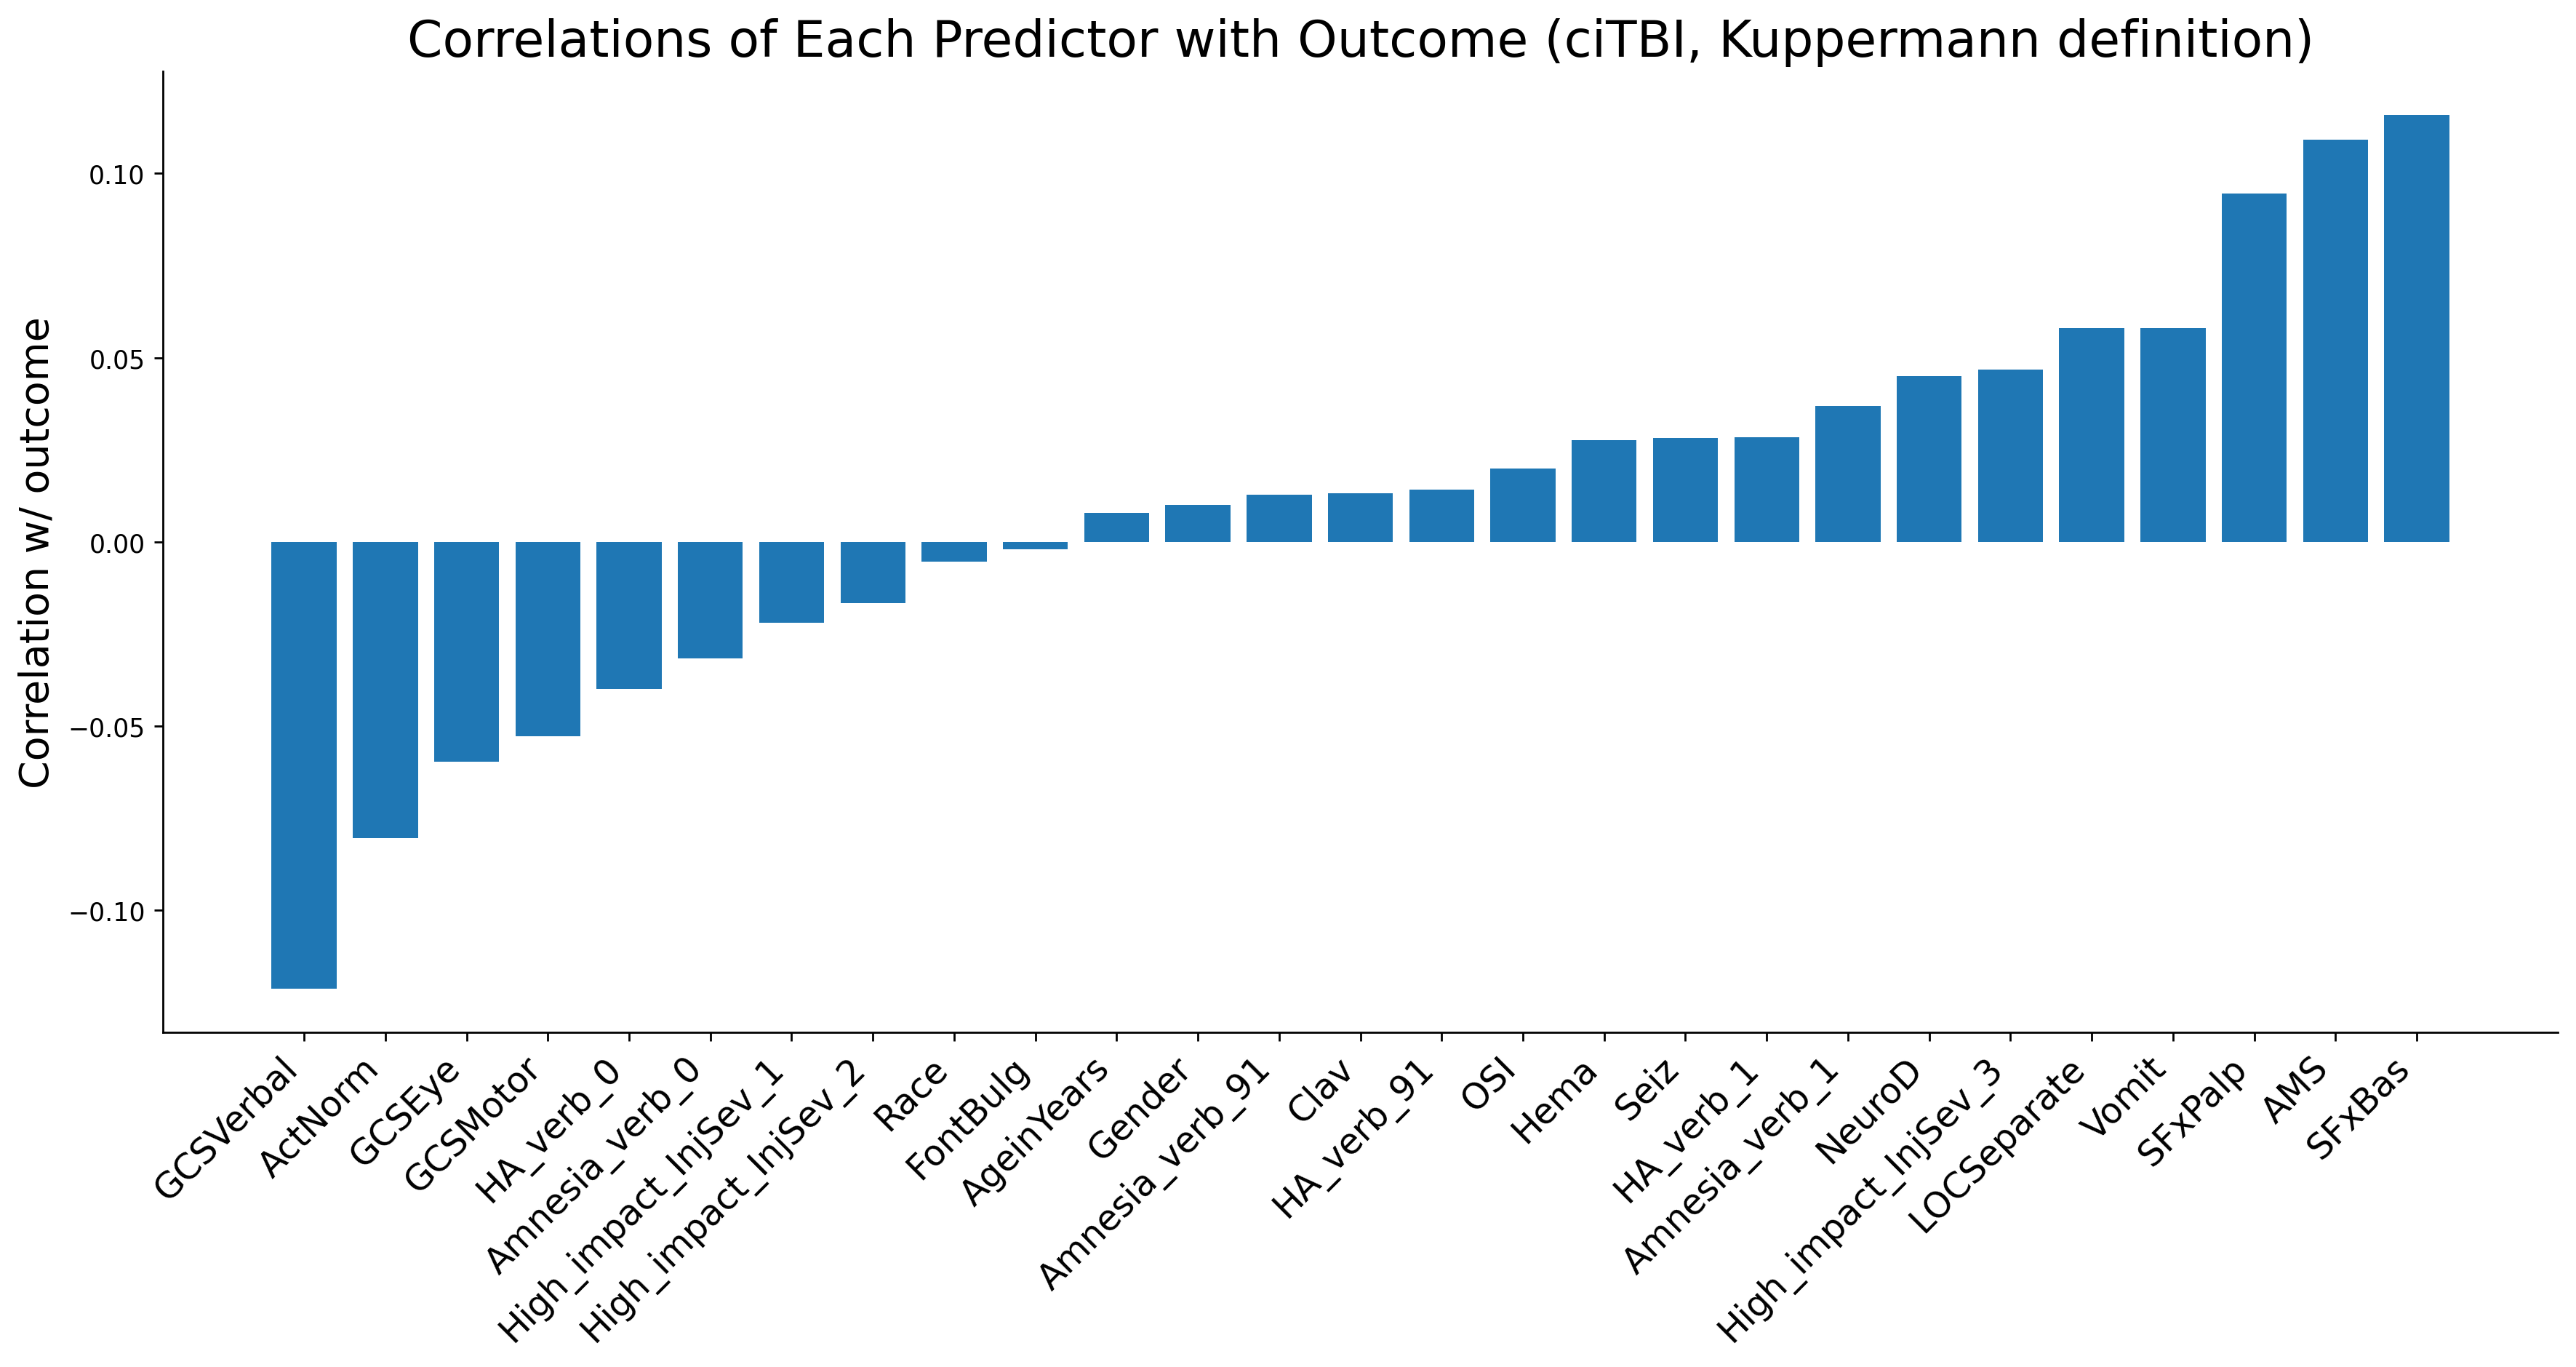

In [145]:
name = 'corr_outcomes.png'

corrs = umbrella_subset.corr()

plt.figure(dpi=250, figsize=(17, 7))
vals = corrs['outcome']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.bar(labs[:-1], vals[args][:-1])
plt.ylabel('Correlation w/ outcome', fontsize = 16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(rotation = 45, ha = 'right', fontsize = 14)
plt.title('Correlations of Each Predictor with Outcome (ciTBI, Kuppermann definition)', fontsize = 20)
#plt.savefig("rulevetting/projects/tbi_pecarn/notebooks/figs/" + name, dpi = 300)

Pretty reasonable! Things to note: 

1. importance of ActNorm in having a negative correlation with the outcome (we thought it was too subjective maybe, but actually pretty highly negatively correlated compared to other variables)

2. GCS verbal seems to have more correlation with the outcome than GCS Eye or GCS Motor (> 2 times the correlation)

3. Gender, Age, Race don't seem like good predictors of the outcome, so we probably don't to include in the classifier (we had talked about age being a possible predictor, but this seems to show otherwise)

Questions:

1. When selecting features for the classifiers, should we pick features that have some correlation outside a neighborhood of 0?

2. Should we analyze the umbrella/sub-feature combos at all, if the umbrella variable is already not super correlated with the outcome? Could argue that it doesn't matter since it doesn't matter overall, but could also argue that certain subcategories might be important relative to the others and could provide fine-grained info for a classification.



### Now, let's look at the umbrella variable/sub-variable combinations to see if any of these could be good predictors as well

In [81]:
# useful function for extracting the relevant columns for each umbrella-subcategory combo

def find_cols(col_name, df):
    
    keys = list(df.keys())
    col_name_keys = []
    
    for key in keys:
        if col_name in key and '92' not in key  and '0' not in key:
            col_name_keys.append(key)
            
    return(col_name_keys)

def subset_umbrella(df, col_name):
    
    cols = find_cols(col_name, df) + ['outcome']
    condition_subset = df[cols]
    condition_subset.drop(col_name, axis = 1, inplace = True)
    
    return(condition_subset)

def make_correlation_outcome_plot(df_subset):
    
    corrs = df_subset.corr()

    plt.figure(dpi=250, figsize=(12, 5))
    vals = corrs['outcome']
    args = np.argsort(vals)
    labs = vals.index.values[args]
    ax = plt.subplot(111)
    plt.bar(labs[:-1], vals[args][:-1])
    plt.ylabel('Correlation w/ outcome', fontsize = 16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xticks(rotation = 45, ha = 'right', fontsize = 14)
    plt.title('Correlations of Subvariables, Conditioning on True Umbrella', fontsize = 20)
    return ax
    
def make_predictor_correlation_plot(df_subset):
    
    corrmap = sns.clustermap(df_subset.corr(), cmap=viz.cmap_div, 
                             vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
    corrmap.ax_row_dendrogram.set_visible(False)
    corrmap.ax_col_dendrogram.set_visible(False)
    corrmap.cax.set_visible(False)
    


#### AMS

Lets first look at AMS. So, of all the individuals with altered mental status, what is the correlation of the presence of the different features with the outcome?

In [ ]:
ams_condition_subset = subset_umbrella(df_train_1, 'AMS')
make_correlation_outcome_plot(ams_condition_subset)

Among individuals with altered mental status, it seems like certain criteria are more correlated with having a ciTBI. Like AMSAgitated_1 vs AMSSleep_1. So, this tells us that if you have altered mental status, it seems like being agitated as the reason might be more indicative of a ciTBI than being sleepy as the reason. This tells us that there might be a dependence of subcategory on whether or not you have a ciTBI. But 'other' being really high also shows that AMS has general importance. 

In [ ]:
make_predictor_correlation_plot(ams_condition_subset)

#### Clav

Next look at clavicle variables. So, of all the individuals with above the clavicle injuries, what is the correlation of the presence of the different features with the outcome?

In [ ]:
clav_condition_subset = subset_umbrella(df_train_1, 'Clav')
make_correlation_plot(clav_condition_subset)

In [ ]:
make_predictor_correlation_plot(clav_condition_subset)

#### SFxBas

Next look at basilar skull fracture variables. So, of all the individuals with above the basilar skull fracture injuries, what is the correlation of the presence of the different features with the outcome?

In [71]:
sfxbas_condition_subset = subset_umbrella(df_train_1, 'SFxBas')
make_correlation_plot(sfxbas_condition_subset)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


NameError: name 'make_correlation_plot' is not defined

In [ ]:
make_predictor_correlation_plot(sfxbas_condition_subset)

Seems like the hem and per variables are particularly associated with the outcome (per is the racoon eyes stuff). But having the racoon eyes is negatively correlated. Probably not a large enough correlation to say anything, but still pretty interesting

#### Neuro

Lets now look at the neuro subvariables

In [ ]:
neuro_condition_subset = subset_umbrella(df_train_1, 'NeuroD')
make_correlation_plot(neuro_condition_subset)

In [ ]:
make_predictor_correlation_plot(neuro_condition_subset)

#### OSI variables

In [ ]:
osi_condition_subset = subset_umbrella(df_train_1, 'OSI')
make_correlation_plot(osi_condition_subset)

In [ ]:
make_predictor_correlation_plot(osi_condition_subset)

Cranial nerves/pupil reflexivity seem super important, among individuals that have neurological deficits

### Takeaway

I think we can use these correlation plots to justify including the subvariables to a certain extent. It seems like eahc subvariable within an umbrella might be differently correlated with the outcome, and might provide more fine-grained/nuanced information in making a decision (whereas just using the umbrella categories could obscure).

## Correlation Plots (Among Umbrella Variables)

In [ ]:
corrmap = sns.clustermap(umbrella_subset.corr(), cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)
corrmap.cax.set_visible(False)

# Official EDA Plots

General plot ideas: prevalence of various parent outcomes, examples of subvariables and their distributions, to motivate the idea of the parent variables and the subvariables

Distribution of gender and race (important for posthoc analysis). I would include this somewhere in the overall EDA plot section, probably along with the age profile, but not really anaylze with respect to race and gender, because there is not a huge precedence for this being important. I'll explore age dependences more later because there is strong evidence certain variables only work for certain ages, but I'll present this info here just to prime a later discussion on misclassification by race, etc. in a posthoc analysis.

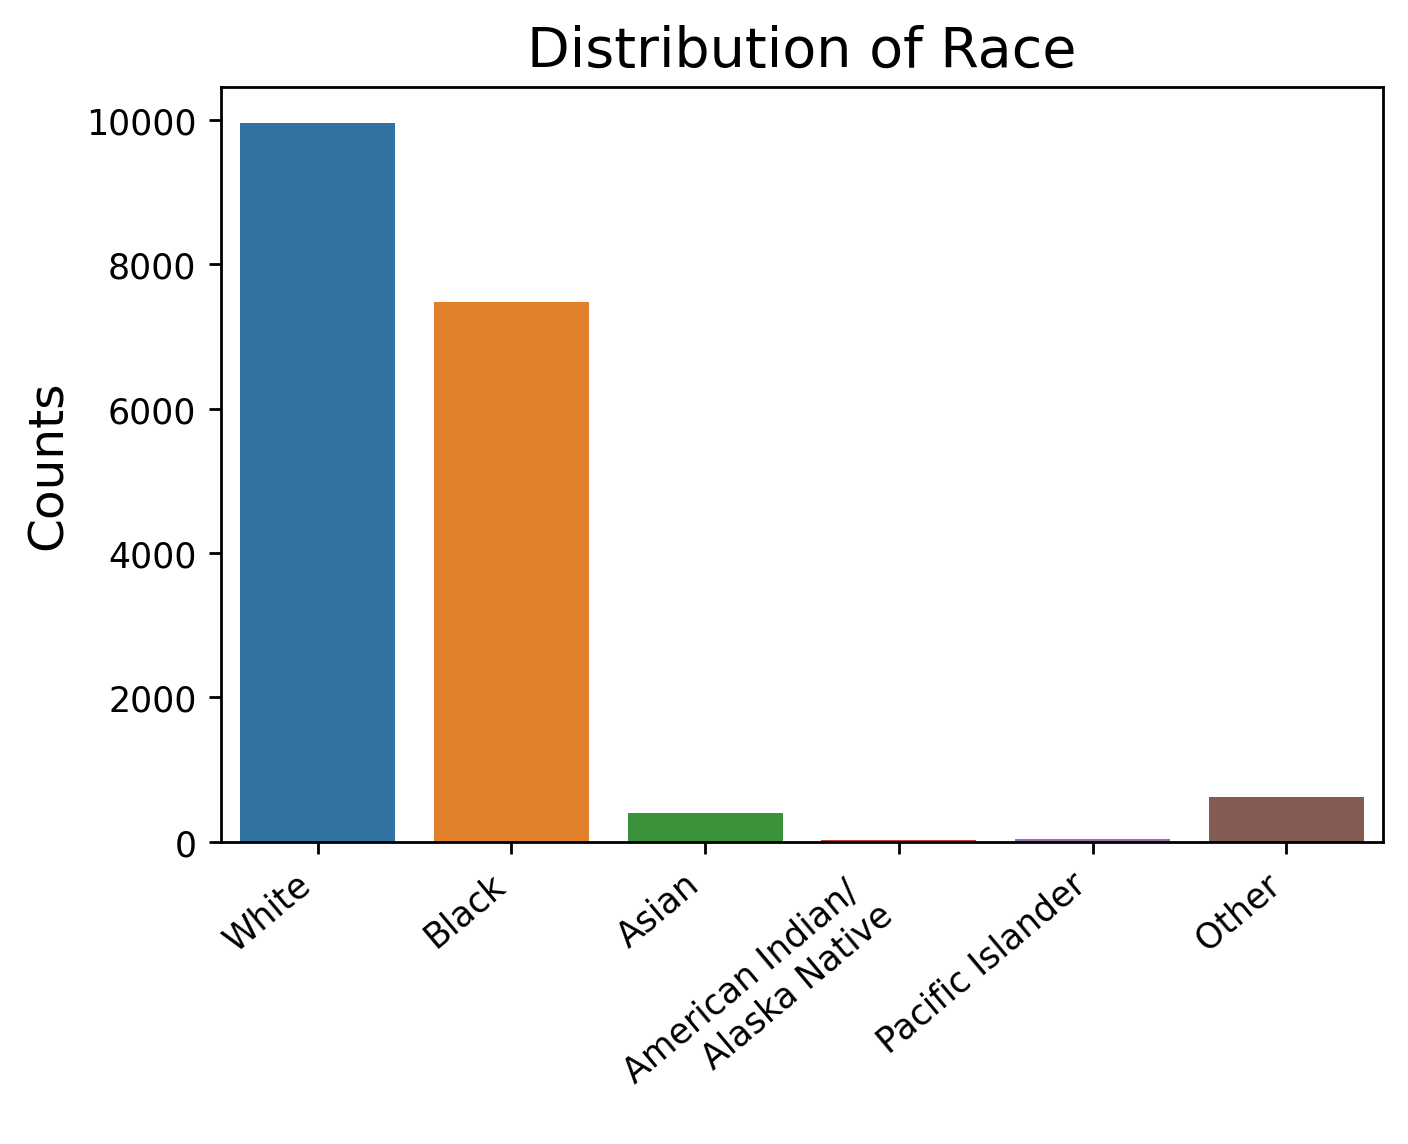

In [19]:
plt.figure(dpi=250, figsize=(6, 4))
ax = sns.countplot(data = df_train_1, x = 'Race')
plt.title('Distribution of Race', fontsize = 16)
plt.ylabel('Counts', fontsize = 14)
plt.xlabel('')
ax.set(xticklabels = (['White', 'Black', 'Asian', 'American Indian/ \n Alaska Native', 'Pacific Islander', 'Other']))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.savefig('/users/jbbutler129/Desktop/race.png', dpi = 300, bbox_inches = 'tight')

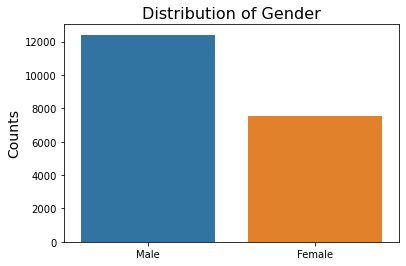

In [18]:
ax = sns.countplot(data = df_train_1, x = 'Gender')
ax.set(xticklabels = (['Male', 'Female']))
plt.title('Distribution of Gender', fontsize = 16)
plt.xlabel('', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.savefig('/users/jbbutler129/Desktop/gender.png', dpi = 300)

## Age & age split

Distribution of Ages in the dataset, seems like doing an age split could make sense, more >= 2 than < 2, but still enough nonetheless

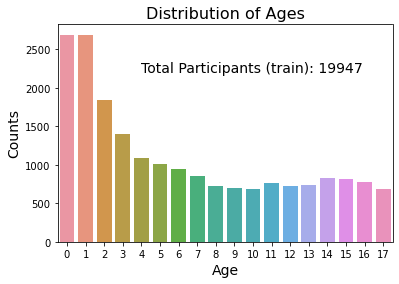

In [17]:
sns.countplot(data = df_train_1, x = 'AgeinYears')
plt.title('Distribution of Ages', fontsize = 16)
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.text(4, 2200, 'Total Participants (train): ' + str(len(df_train_1)), fontsize = 14)
plt.savefig('/users/jbbutler129/Desktop/ages.png', dpi = 300)



Roughly even if doing an age split, interesting how there's a lot of ciTBI for the younger ages than the older ones, but also a lot more patients than the older ones. Seems roughly distributed evenly (so if we make a classification rule, not going to be hugely lopsided one way or another)

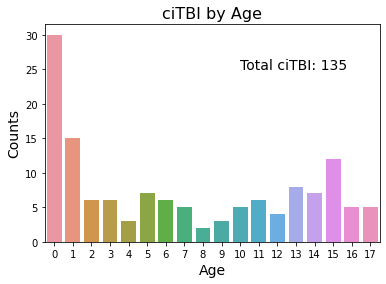

In [12]:
sns.countplot(data = df_train_1[df_train_1['outcome'] == 1], x = 'AgeinYears')
plt.title('ciTBI by Age', fontsize = 16)
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
total_tbi = len(df_train_1[df_train_1['outcome'] == 1])
plt.text(10, 25, 'Total ciTBI: ' + str(total_tbi), fontsize = 14)
plt.savefig('/users/jbbutler129/Desktop/ciTBI_age.png', dpi = 300)


Now, the main concern for using an age split is that some variables which could be important for one age group in predicting TBI are not present in the other age group, so mixing could confuse any decision tree algorithm and cause us to miss diagnoses in certain age groups or just produce confusing rule sets. Let's look at variables which our physician told us are important for predicting ciTBI in different age groups (or are preferential to certain age groups), and see the distributions of answers/missing responses by age group, to justify doing an age split.

First, we look at anterior fontanelle bulging, which should be really only prevalent in children that are really young. We see that there are only 11 instances of anterior fontanelle bulging, and they are only in children <= 2. Everybody else is 0, because theirs has closed up. This was also recommended by our physician to keep, so we will keep it.

In [22]:
plt_df = df_train_1.copy()
plt_df['age<=2'] = plt_df['AgeinYears'] <= 2
plt_df_young = plt_df[plt_df['age<=2'] == 1]

About Fontanelle Bulging, just say that there's only 11 observations, but that they are all in the lower age group, so if this is a good predictor of ciTBI, it would only be important for the younger age group (wouldn't really mean anything for the older people).

In the below plots, we see that certain variables which, by domain knowledge, are important for predicting TBIs, are more prevalently answered for certain age groups. For example, 80% of the observations in the <=2 age group had preverbal marked as this variable, so this variable would show nothing in predicting TBI (different kinds of information available). This motivates doing a group split, and using separate covariates for each group to predict.

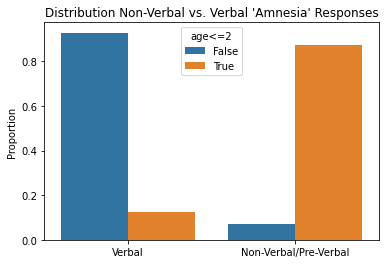

In [39]:
ax = (plt_df['Amnesia_verb_91']
 .groupby(plt_df['age<=2'])
 .value_counts(normalize=True)
 .rename('Proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='Amnesia_verb_91', y='Proportion', hue='age<=2'))
plt.title('Distribution Non-Verbal vs. Verbal \'Amnesia\' Responses')
ax.set(xticklabels = (['Verbal', 'Non-Verbal/Pre-Verbal']))
plt.xlabel('')
plt.savefig('/users/jbbutler129/Desktop/verb_amn.png', dpi = 300)


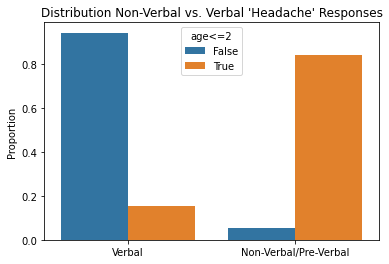

In [41]:
ax = (plt_df['HA_verb_91']
 .groupby(plt_df['age<=2'])
 .value_counts(normalize=True)
 .rename('Proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='HA_verb_91', y='Proportion', hue='age<=2'))
plt.title('Distribution Non-Verbal vs. Verbal \'Headache\' Responses')
ax.set(xticklabels = (['Verbal', 'Non-Verbal/Pre-Verbal']))
plt.xlabel('')
plt.savefig('/users/jbbutler129/Desktop/verb_HA.png', dpi = 300)


Age-specific variables for each age group:

1. younger: include Anterior Fontanelle Bulging, but no headache variables or amnesia variables
2. older: include the headache variables and amnesia variables, but no anterior fontanelle bulging

More motivation for splitting up the data: different GCS criteria for different age groups (GCS vs. pediatric GCS at this age split, so if we have a classifier with all of the data points, GCS scores might mean something different for someone less than 2 vs older than 2, metrics might be different).

Probably won't include the 3 plots below, since the distributions of the scores don't really seem to show much

<AxesSubplot:xlabel='GCSVerbal', ylabel='proportion'>

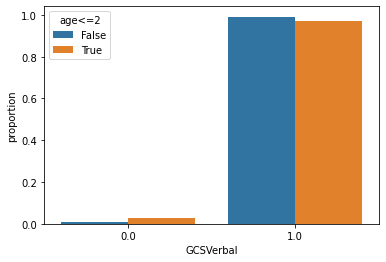

In [81]:
(plt_df['GCSVerbal']
 .groupby(plt_df['age<=2'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='GCSVerbal', y='proportion', hue='age<=2'))

<AxesSubplot:xlabel='GCSMotor', ylabel='proportion'>

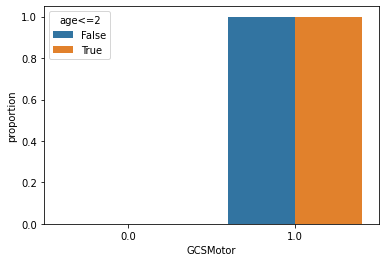

In [83]:
(plt_df['GCSMotor']
 .groupby(plt_df['age<=2'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='GCSMotor', y='proportion', hue='age<=2'))

<AxesSubplot:xlabel='GCSEye', ylabel='proportion'>

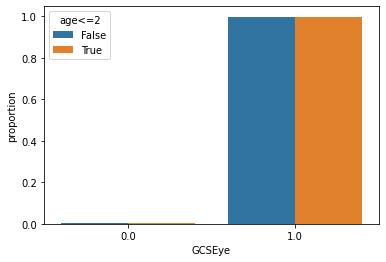

In [87]:
(plt_df['GCSEye']
 .groupby(plt_df['age<=2'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='GCSEye', y='proportion', hue='age<=2'))

Wondering if there is a difference in the proportion of ciTBIs among people with suboptimal GCSVerbal or GCSMotor or GCSEye scores among each age group, since it seems like they are being held to different standards (comparability!) It seems below like for the verbal and eye scores, the among individuals with suboptimal GCS scores, the distribution of the outcome is about the same among the age groups. This is not so with the motor scores. A suboptimal GCS motor seems much more indicative of TBI in the older children than the younger children. This may be an effect of the different rules. Regardless, we opt to split along age for this reason as well, and when building an age-invariant classifier, we should probably not include these variables since the distributions. This could also probably be put in a contingency table.

Will probably include these because I think these are interesting.

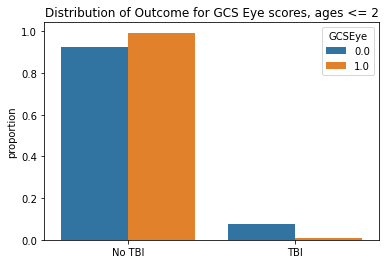

In [50]:
plt_df_2 = plt_df[plt_df['age<=2'] == 1]


ax = (plt_df_2['outcome']
 .groupby(plt_df_2['GCSEye'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='outcome', y='proportion', hue='GCSEye'))

plt.title('Distribution of Outcome for GCS Eye scores, ages <= 2')
ax.set(xticklabels = (['No TBI', 'TBI']))
plt.xlabel('')
plt.savefig('/users/jbbutler129/Desktop/outcome_eye_<=2.png', dpi = 300)


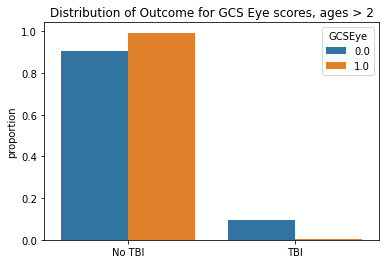

In [51]:
plt_df_2 = plt_df[plt_df['age<=2'] == 0]


ax = (plt_df_2['outcome']
 .groupby(plt_df_2['GCSEye'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='outcome', y='proportion', hue='GCSEye'))

plt.title('Distribution of Outcome for GCS Eye scores, ages > 2')
ax.set(xticklabels = (['No TBI', 'TBI']))
plt.xlabel('')
plt.savefig('/users/jbbutler129/Desktop/outcome_eye_>2.png', dpi = 300)

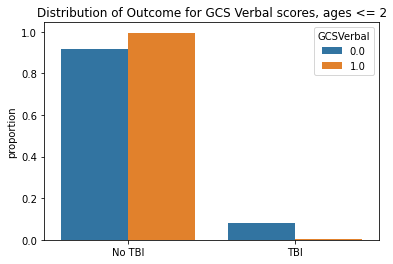

In [52]:
plt_df_2 = plt_df[plt_df['age<=2'] == 1]


ax = (plt_df_2['outcome']
 .groupby(plt_df_2['GCSVerbal'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='outcome', y='proportion', hue='GCSVerbal'))

plt.title('Distribution of Outcome for GCS Verbal scores, ages <= 2')
ax.set(xticklabels = (['No TBI', 'TBI']))
plt.xlabel('')
plt.savefig('/users/jbbutler129/Desktop/outcome_verb_<=2.png', dpi = 300)


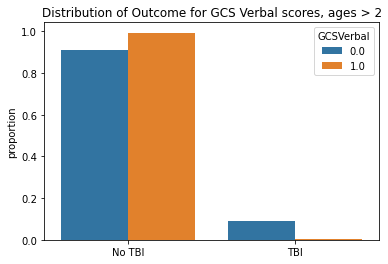

In [53]:
plt_df_2 = plt_df[plt_df['age<=2'] == 0]


ax = (plt_df_2['outcome']
 .groupby(plt_df_2['GCSVerbal'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='outcome', y='proportion', hue='GCSVerbal'))

plt.title('Distribution of Outcome for GCS Verbal scores, ages > 2')
ax.set(xticklabels = (['No TBI', 'TBI']))
plt.xlabel('')
plt.savefig('/users/jbbutler129/Desktop/outcome_verb_>2.png', dpi = 300)



But we also notice that there are only a few observations with suboptimal GCS motor scores among the individuals <= 2, so it seems like the criteria might be a bit different, than for older than 2

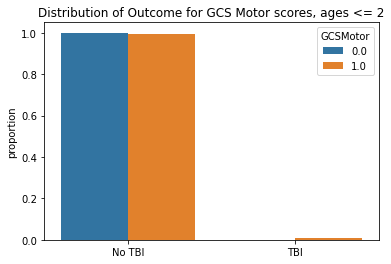

In [55]:
plt_df_2 = plt_df[plt_df['age<=2'] == 1]


ax = (plt_df_2['outcome']
 .groupby(plt_df_2['GCSMotor'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='outcome', y='proportion', hue='GCSMotor'))

plt.title('Distribution of Outcome for GCS Motor scores, ages <= 2')
ax.set(xticklabels = (['No TBI', 'TBI']))
plt.xlabel('')
plt.savefig('/users/jbbutler129/Desktop/outcome_motor_<=2.png', dpi = 300)



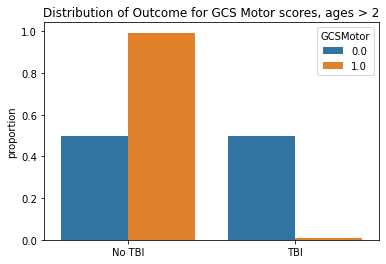

In [56]:
plt_df_2 = plt_df[plt_df['age<=2'] == 0]

ax = (plt_df_2['outcome']
 .groupby(plt_df_2['GCSMotor'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='outcome', y='proportion', hue='GCSMotor'))

plt.title('Distribution of Outcome for GCS Motor scores, ages > 2')
ax.set(xticklabels = (['No TBI', 'TBI']))
plt.xlabel('')
plt.savefig('/users/jbbutler129/Desktop/outcome_motor_>2.png', dpi = 300)



This could all probably just be put in a big contingency table, but I'm not sure how to implement that.

Next, let's try to look for some age-invariant variables, to justify also looking for an age-invariant classifier. Some more variables: the distributions are going to be quite similar! So, we have reason to believe that, we can use common sense to decide which objective variables we could use in a classifier that transcends age. Seems like the other variables would not have an age dependence, no reason to believe. Whereas there is an obvious case with the ones that require verbalization, or anterior fontanelle bulging, or GCSMotor.

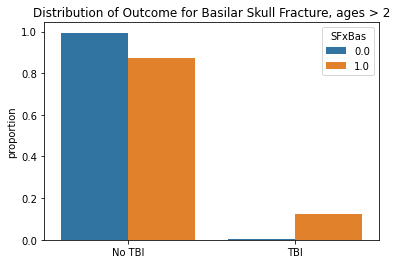

In [57]:
plt_df_2 = plt_df[plt_df['age<=2'] == 0]


ax = (plt_df_2['outcome']
 .groupby(plt_df_2['SFxBas'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='outcome', y='proportion', hue='SFxBas'))

plt.title('Distribution of Outcome for Basilar Skull Fracture, ages > 2')
ax.set(xticklabels = (['No TBI', 'TBI']))
plt.xlabel('')
plt.savefig('/users/jbbutler129/Desktop/outcome_sfxbas_>2.png', dpi = 300)



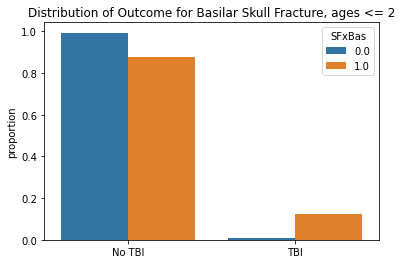

In [58]:
plt_df_2 = plt_df[plt_df['age<=2'] == 1]


ax = (plt_df_2['outcome']
 .groupby(plt_df_2['SFxBas'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='outcome', y='proportion', hue='SFxBas'))

plt.title('Distribution of Outcome for Basilar Skull Fracture, ages <= 2')
ax.set(xticklabels = (['No TBI', 'TBI']))
plt.xlabel('')
plt.savefig('/users/jbbutler129/Desktop/outcome_sfxbas_<=2.png', dpi = 300)


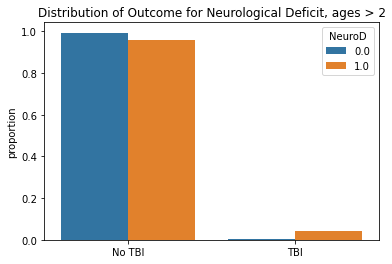

In [64]:
plt_df_2 = plt_df[plt_df['age<=2'] == 0]


ax = (plt_df_2['outcome']
 .groupby(plt_df_2['NeuroD'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='outcome', y='proportion', hue='NeuroD'))

plt.title('Distribution of Outcome for Neurological Deficit, ages > 2')
ax.set(xticklabels = (['No TBI', 'TBI']))
plt.xlabel('')
plt.savefig('/users/jbbutler129/Desktop/outcome_neuroD_>2.png', dpi = 300)


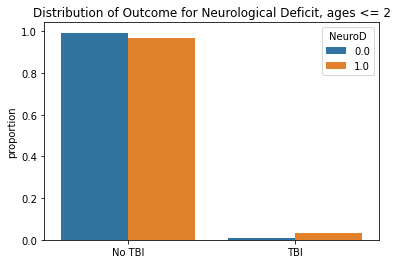

In [63]:
plt_df_2 = plt_df[plt_df['age<=2'] == 1]


ax = (plt_df_2['outcome']
 .groupby(plt_df_2['NeuroD'])
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .pipe((sns.barplot, "data"), x='outcome', y='proportion', hue='NeuroD'))

plt.title('Distribution of Outcome for Neurological Deficit, ages <= 2')
ax.set(xticklabels = (['No TBI', 'TBI']))
plt.xlabel('')
plt.savefig('/users/jbbutler129/Desktop/outcome_neuroD_<=2.png', dpi = 300)

## 2. Argument in Favor of Looking at Subvariables

For many of our variables, there are subvariables which offer more specific information about the parent indicator. Would it be necessary to include these variables, would including these variables offer the possibility of better classifiers, or would the potential cost of lack of interpretability (too many variables and indicators) make it not worth it?

Let's plot an example: look at AMS variables. Seems like some altered mental status variables are much more important/more highly correlated with the outcome than other variables.

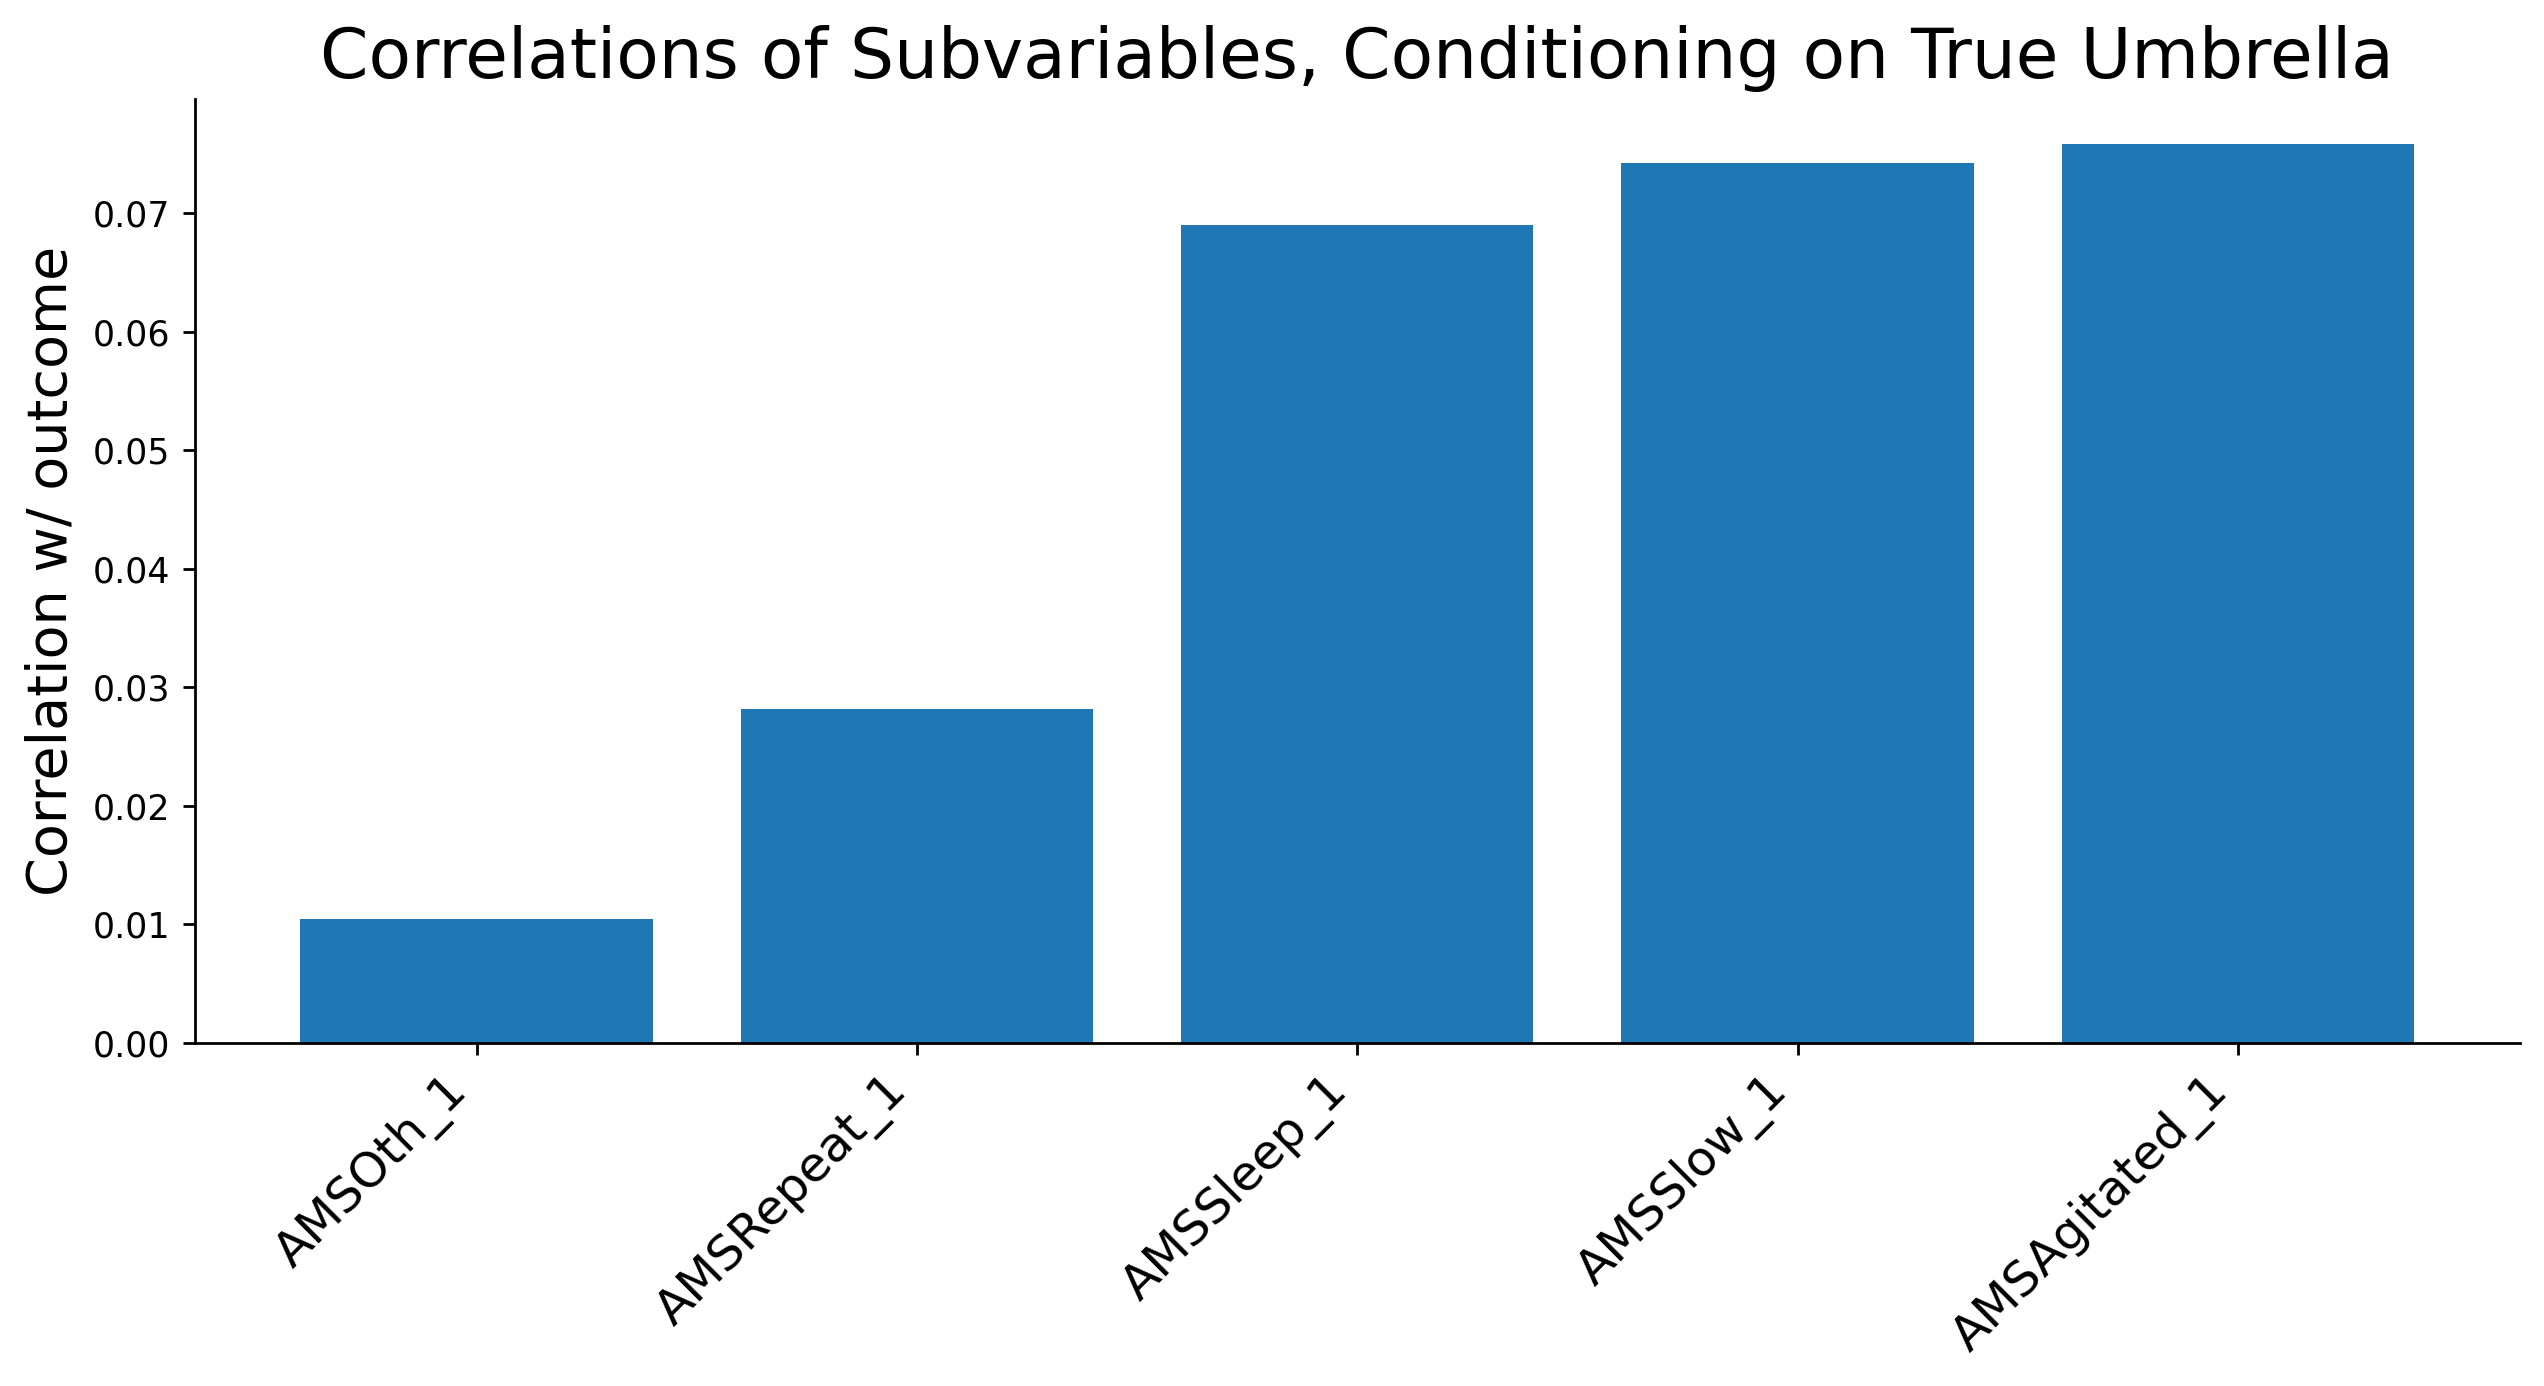

In [75]:
ams_condition_subset = subset_umbrella(df_train_1, 'AMS')
make_correlation_outcome_plot(ams_condition_subset)

Now, look at the skull fracture variables. It seems like having a skull fracture and having it be a 'hem' (whatever that means, I forgot) is much more highly correlated with the outcome than the other ones. So, there is some benefit to having more fine-grained detail. Consider if someone had one of the other skull fracture variables, but they were nonetheless marked as an overall skull fracture. The rule might tell them they have a TBI because the rule might think skull fracture is important, but actually, its only a type of skull fracture that is important. So, we would be giving someone an unnecessary CT scan, which is exactly what we want to avoid. So, we can show these two plots as examples to show that, allowing a decision tree/rule finder to decide which subvariables are important could be beneficial. The tradeoff is that it might be harder to converge on an interpretable rule with so many variables.

<ipython-input-109-209dba33242e>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels = (['Raccoon eyes', 'Battle\'s sign', 'Rhinorrhea', 'Otorrhea', 'Hemotympanum']))


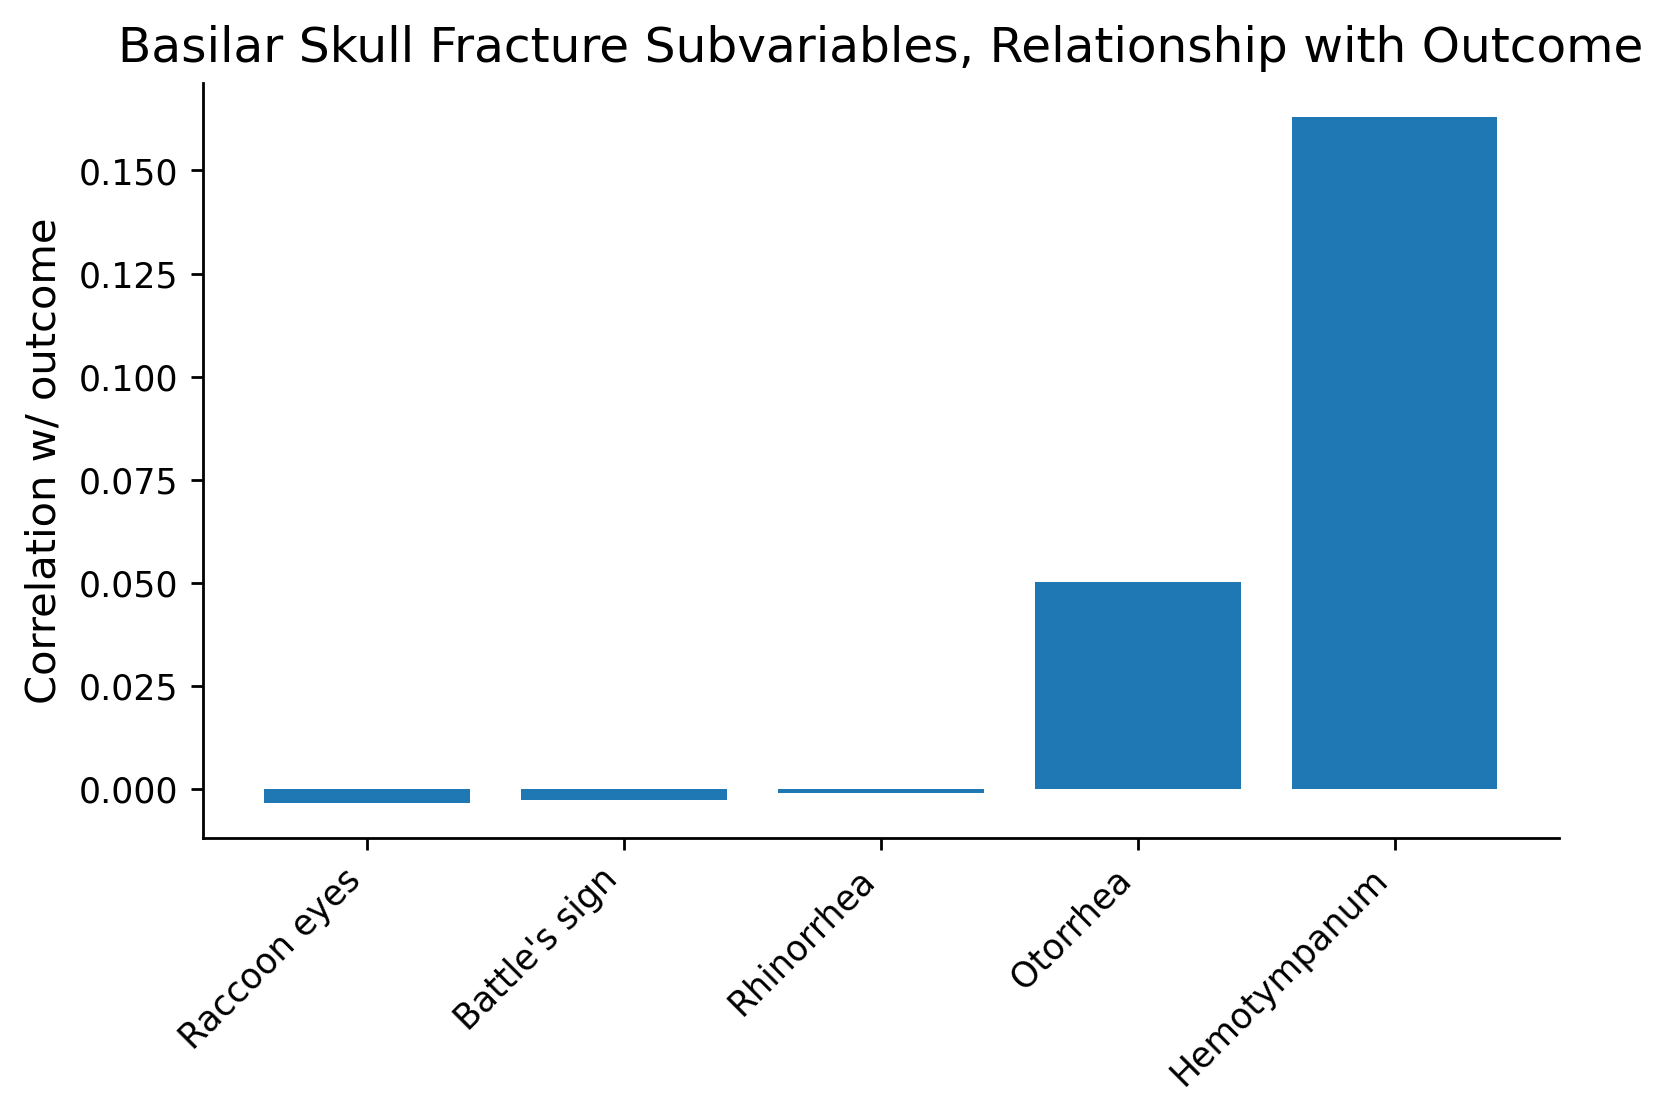

In [109]:
sfx_subset = subset_umbrella(df_train_1, 'SFxBas')
corrs = sfx_subset.corr()

plt.figure(dpi=250, figsize=(7, 4))
vals = corrs['outcome']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.bar(labs[:-1], vals[args][:-1])
plt.ylabel('Correlation w/ outcome', fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xticklabels = (['Raccoon eyes', 'Battle\'s sign', 'Rhinorrhea', 'Otorrhea', 'Hemotympanum']))
plt.xticks(rotation = 45, ha = 'right', fontsize = 10)
plt.title('Basilar Skull Fracture Subvariables, Relationship with Outcome', fontsize = 14)
plt.savefig('/users/jbbutler129/Desktop/basilar_outcome.png', dpi = 300, bbox_inches = 'tight')


<ipython-input-110-d4b737d01cde>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels = (['Other', 'Repetitive', 'Sleepy', 'Slow to \n Respond', 'Agitated']))


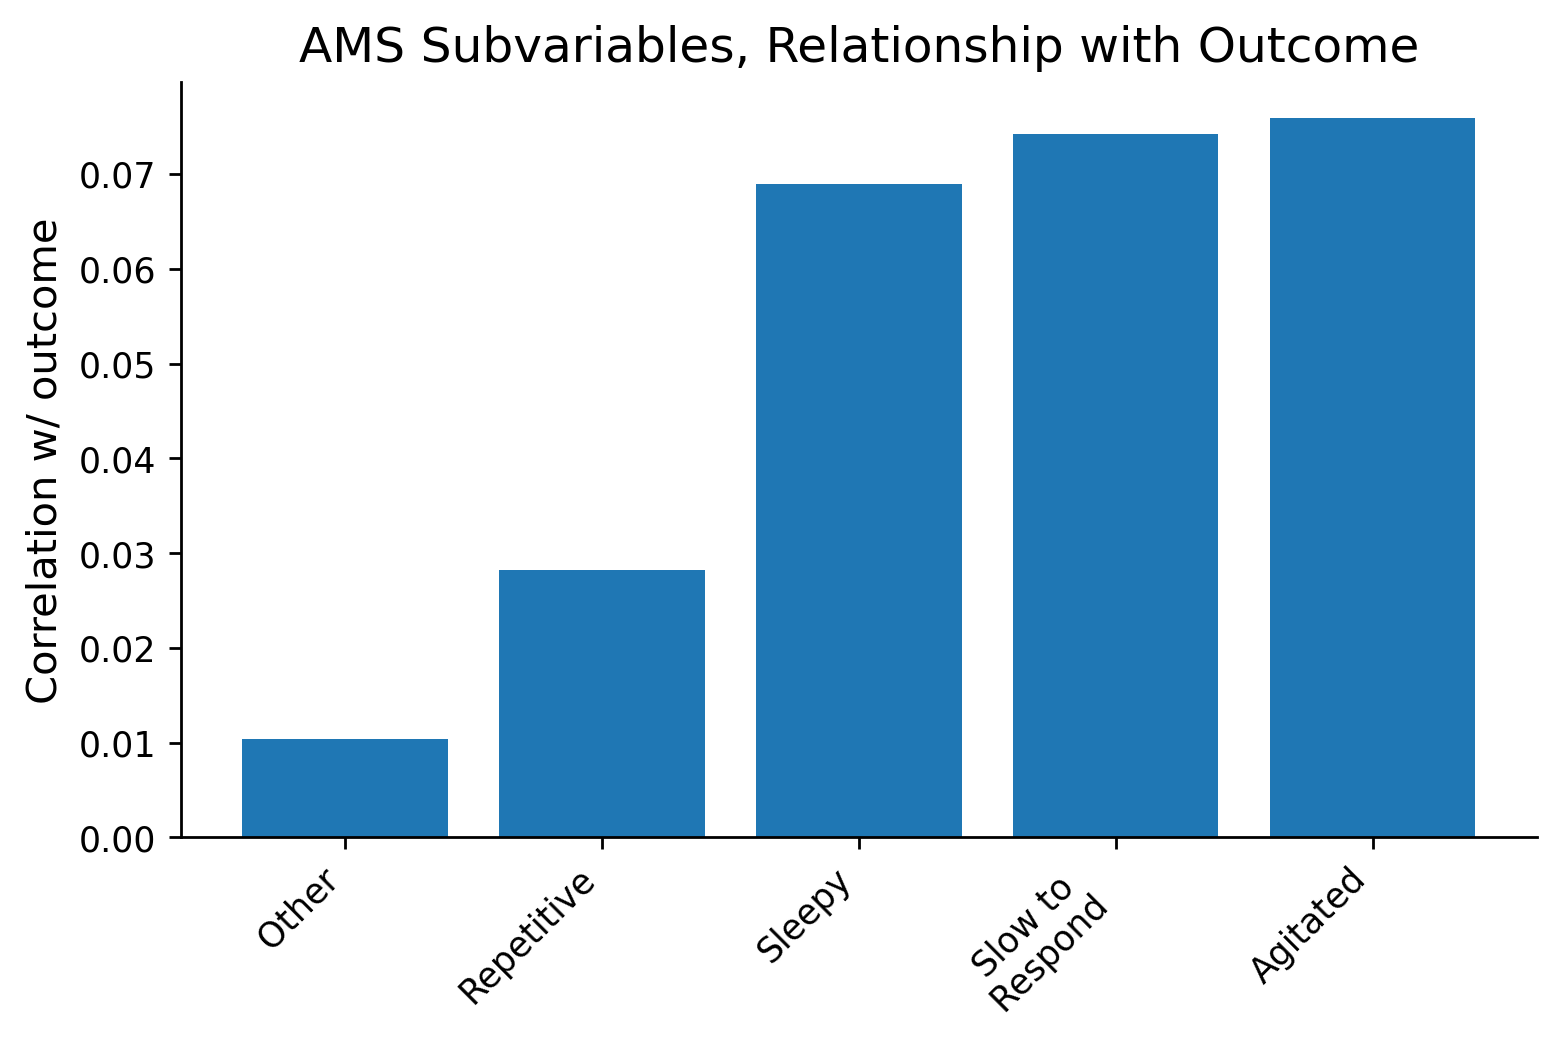

In [110]:
ams_subset = subset_umbrella(df_train_1, 'AMS')
corrs = ams_subset.corr()

plt.figure(dpi=250, figsize=(7, 4))
vals = corrs['outcome']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.bar(labs[:-1], vals[args][:-1])
plt.ylabel('Correlation w/ outcome', fontsize = 12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xticklabels = (['Other', 'Repetitive', 'Sleepy', 'Slow to \n Respond', 'Agitated']))
plt.xticks(rotation = 45, ha = 'right', fontsize = 10)
plt.title('AMS Subvariables, Relationship with Outcome', fontsize = 14)
plt.savefig('/users/jbbutler129/Desktop/ams_outcome.png', dpi = 300, bbox_inches = 'tight')

## 3. Argument Against Looking at Subvariables

In [112]:
keys_to_keep_old = ['LOCSeparate',
 'Seiz',
 'ActNorm',
 'Vomit',
 'GCSEye',
 'GCSVerbal',
 'GCSMotor',
 'AMS',
 'SFxPalp',
 'SFxBas',
 'Hema',
 'Clav',
 'NeuroD',
 'OSI',
 'AgeinYears',
 'outcome',
 'High_impact_InjSev_1',
 'High_impact_InjSev_2',
 'High_impact_InjSev_3',
 'Amnesia_verb_1',
 'HA_verb_1']

keys_to_keep_young = ['LOCSeparate',
 'Seiz',
 'ActNorm',
 'Vomit',
 'GCSEye',
 'GCSVerbal',
 'GCSMotor',
 'AMS',
 'SFxPalp',
 'SFxBas',
 'Hema',
 'Clav',
 'NeuroD',
 'OSI',
 'AgeinYears',
 'outcome',
 'High_impact_InjSev_1',
 'High_impact_InjSev_2',
 'High_impact_InjSev_3',
 'FontBulg']

These variables provide a lot of interpretability, a lot of information it seems, even in exploratory plots, it makes sense, and if we try to find an optimal decision rule, the steps would probably be pretty intuitive since the variables have good relationships with the outcome, and there's fewer variables.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-120-66e407c36bc7>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels = (['GCS Verbal', 'Act Normal', 'GCS Eye', 'GCS Motor', 'Low Severity Injury', 'Moderate Severity Injury', 'Clav', 'OSI', 'Hematoma', 'Seizure', 'Headache', 'Amnesia', 'Neurological Deficit', 'High Severity Injury', 'Loss of Consciousness', 'Vomiting', 'Palpable Skull Fracture', 'AMS', 'Basilar Skull Fracture']))


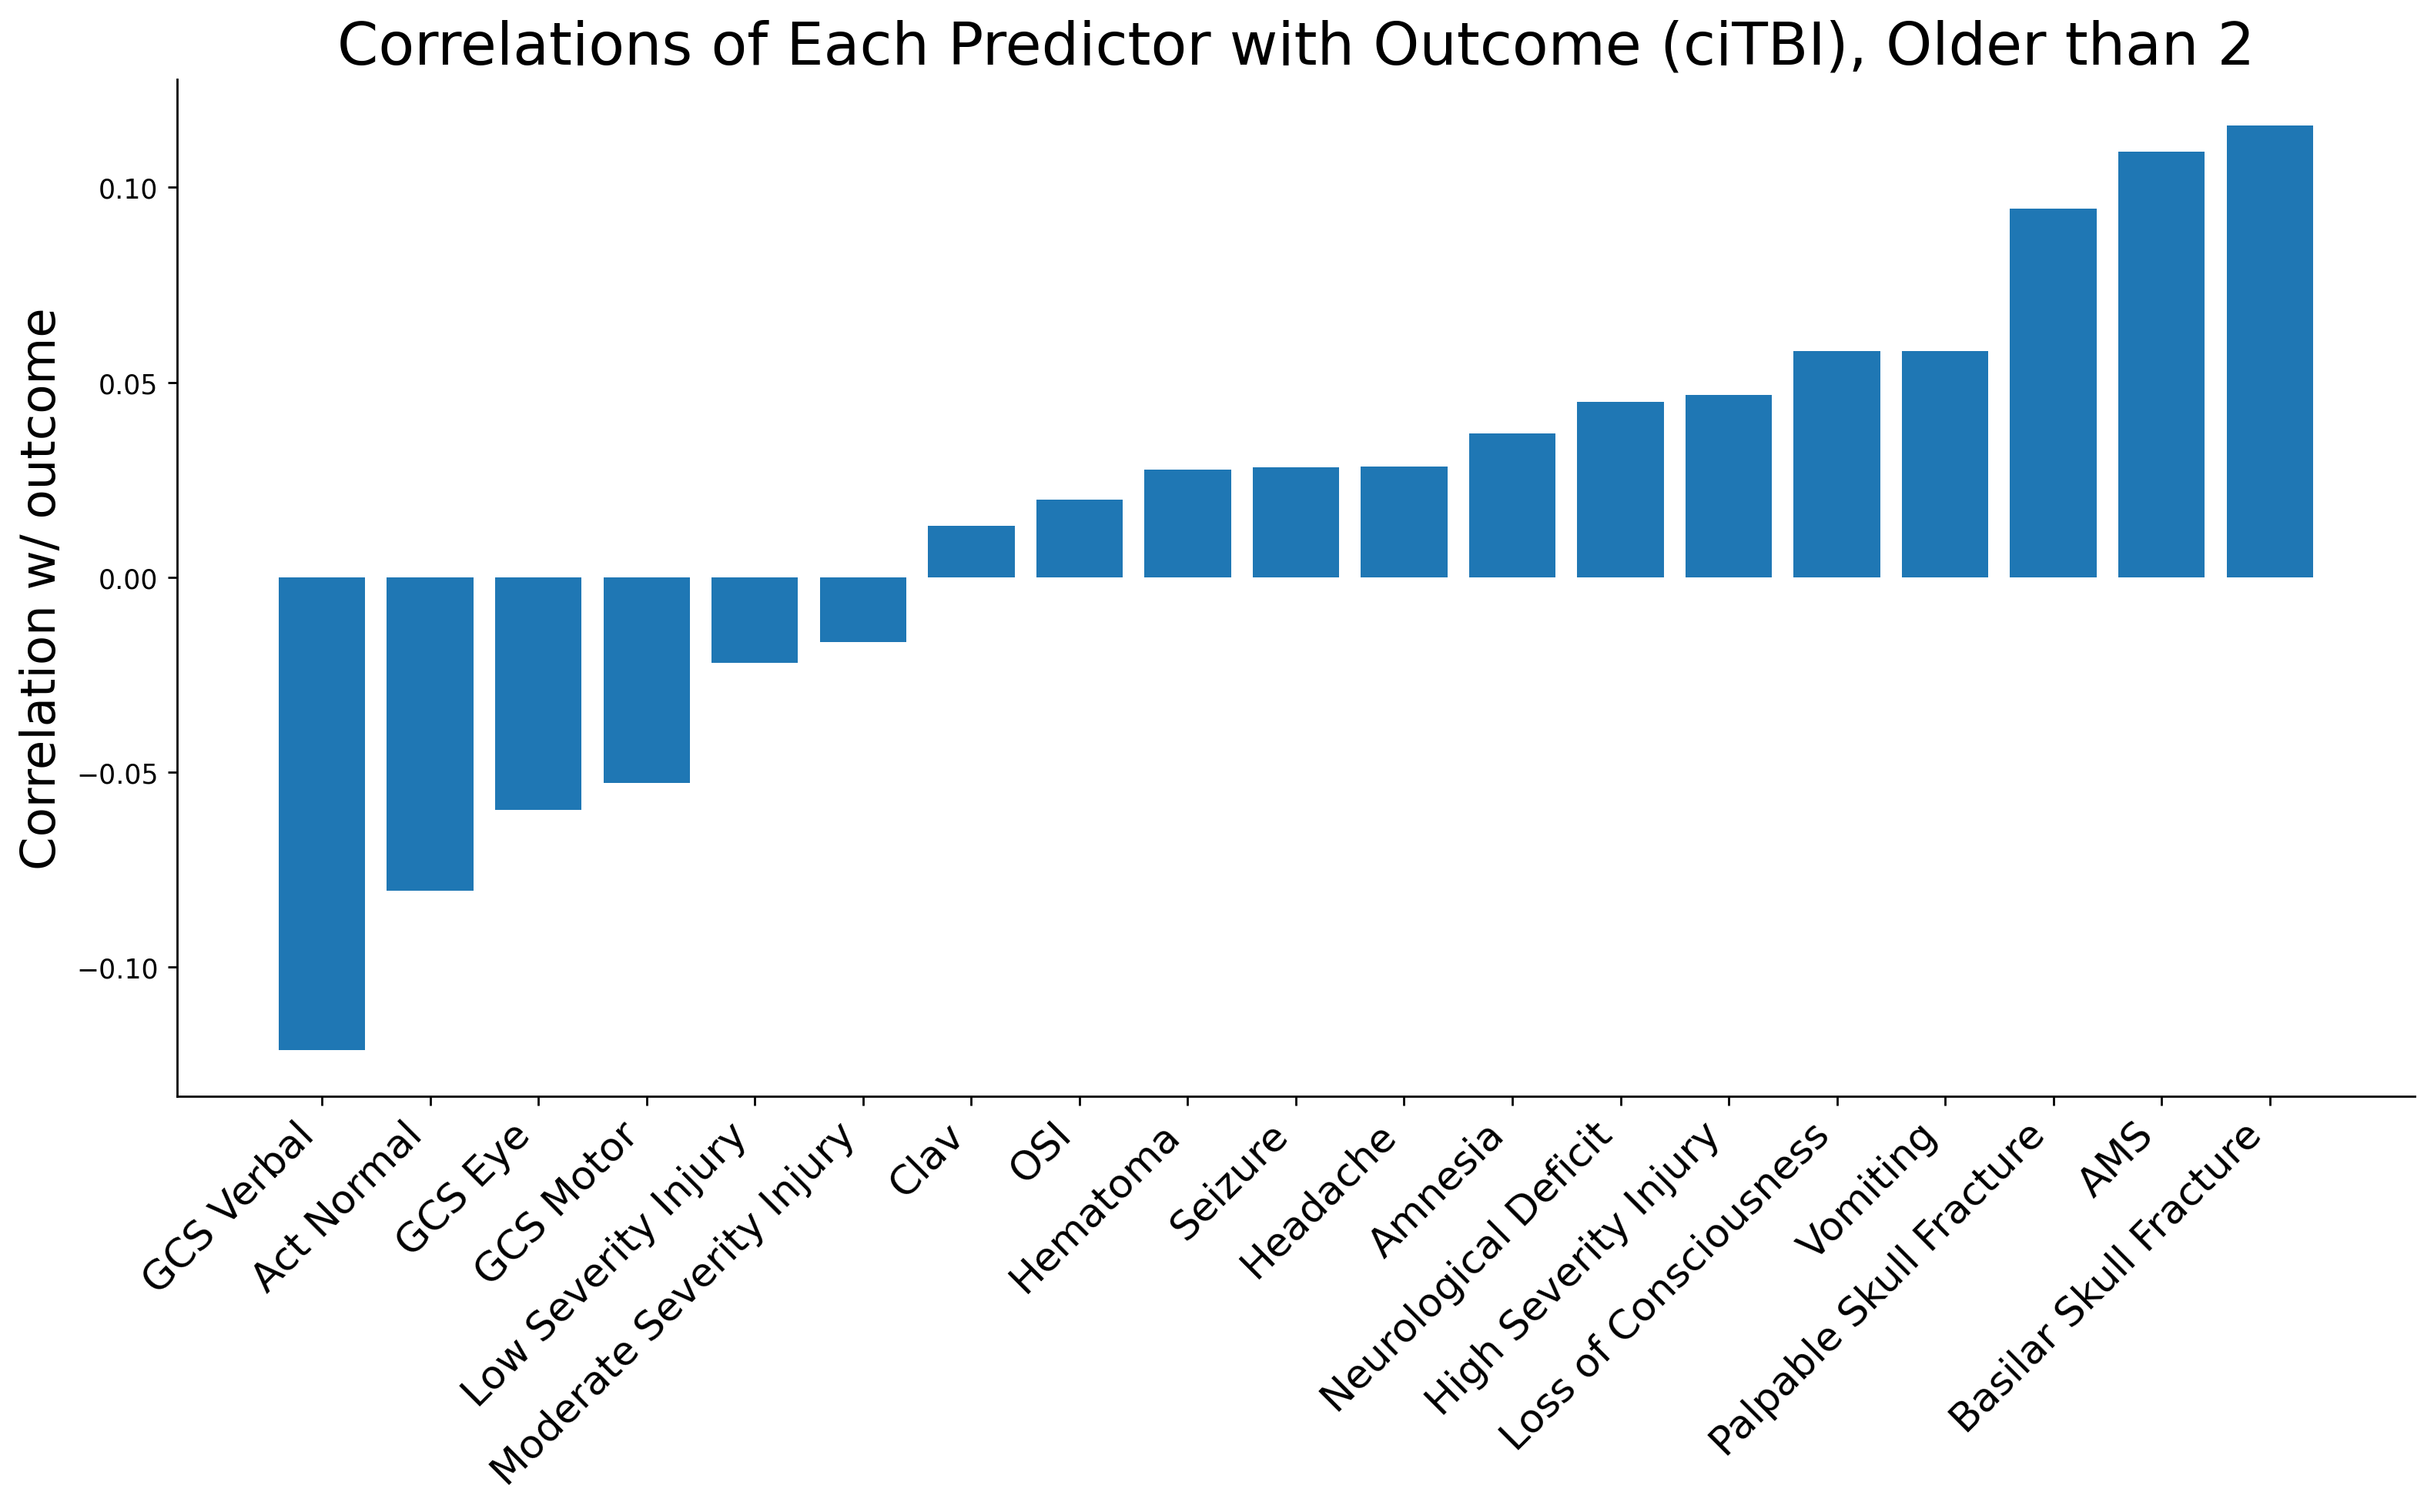

In [120]:
# reproduce plots from above to possibly justify ignoring the subvariables and just looking at the parent variable classes

umbrella_subset_old = df_train_1[keys_to_keep_old]
umbrella_subset_old[umbrella_subset_old['AgeinYears'] > 2]
umbrella_subset_old.drop('AgeinYears', axis = 1, inplace = True)

corrs = umbrella_subset_old.corr()

plt.figure(dpi=250, figsize=(15, 7))
vals = corrs['outcome']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.bar(labs[:-1], vals[args][:-1])
plt.ylabel('Correlation w/ outcome', fontsize = 18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xticklabels = (['GCS Verbal', 'Act Normal', 'GCS Eye', 'GCS Motor', 'Low Severity Injury', 'Moderate Severity Injury', 'Clav', 'OSI', 'Hematoma', 'Seizure', 'Headache', 'Amnesia', 'Neurological Deficit', 'High Severity Injury', 'Loss of Consciousness', 'Vomiting', 'Palpable Skull Fracture', 'AMS', 'Basilar Skull Fracture']))
plt.xticks(rotation = 45, ha = 'right', fontsize = 15)
plt.title('Correlations of Each Predictor with Outcome (ciTBI), Older than 2', fontsize = 22)
plt.savefig('/users/jbbutler129/Desktop/parent_older.png', dpi = 300, bbox_inches = 'tight')


This plot gives not only a notion of variables being important for classifying observations in the different age groups (and why we probably wouldn't need to consider the subvariables), but also, it tells us that among the variables that exist for each age group (supposedly age-invariant variables), the age invariance does seem pretty true, in line with some of the variables we noticed above. So, this further justifies using a common subset of the variables for a single classifier, since for each age group it seems like their relationship with the outcome is roughly the same.

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-125-0d60f4cbff2f>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels = (['GCS Verbal', 'Act Normal', 'GCS Eye', 'GCS Motor', 'Low Severity Injury', 'Moderate Severity Injury', 'Anterior Fontanelle Bulging', 'Clav', 'OSI', 'Hematoma', 'Seizure', 'Neurological Deficit', 'High Severity Injury', 'Loss of Consciousness', 'Vomiting', 'Palpable Skull Fracture', 'AMS', 'Basilar Skull Fracture']))


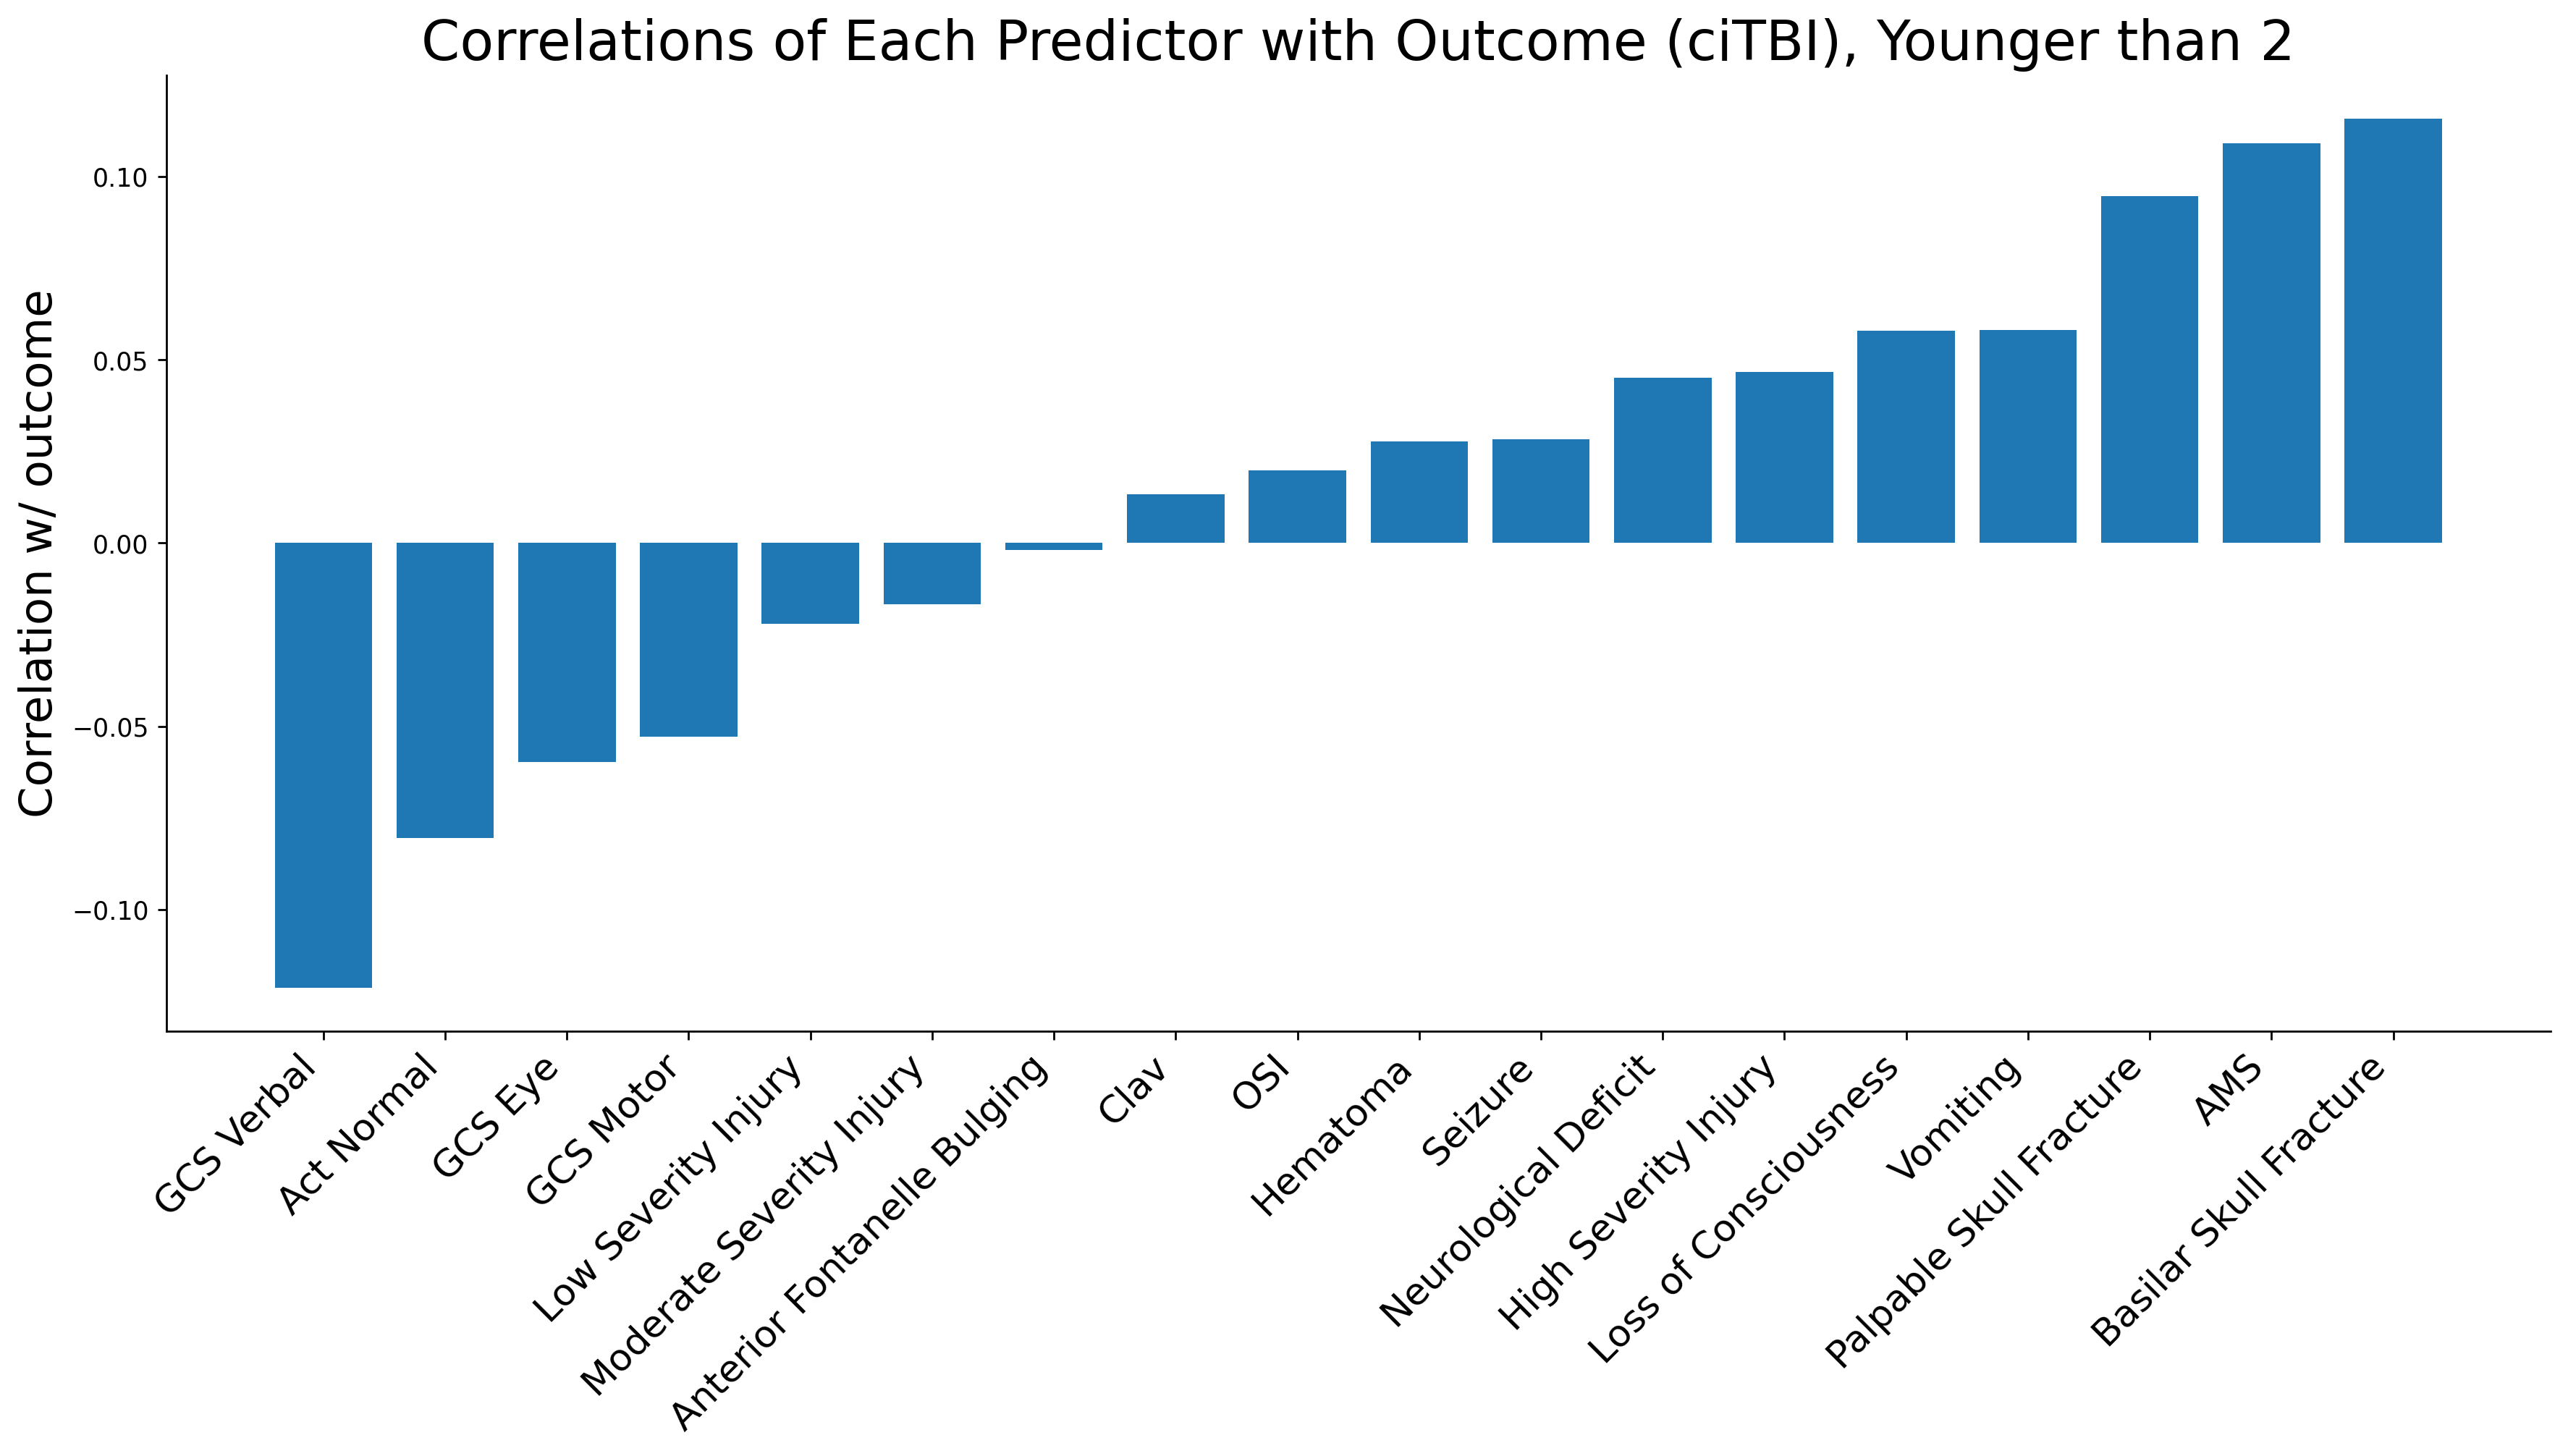

In [125]:
# reproduce plots from above to possibly justify ignoring the subvariables and just looking at the parent variable classes

umbrella_subset_young = df_train_1[keys_to_keep_young]
umbrella_subset_young[umbrella_subset_young['AgeinYears'] <= 2]
umbrella_subset_young.drop('AgeinYears', axis = 1, inplace = True)

corrs = umbrella_subset_young.corr()

plt.figure(dpi=250, figsize=(17, 7))
vals = corrs['outcome']
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.bar(labs[:-1], vals[args][:-1])
plt.ylabel('Correlation w/ outcome', fontsize = 18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(xticklabels = (['GCS Verbal', 'Act Normal', 'GCS Eye', 'GCS Motor', 'Low Severity Injury', 'Moderate Severity Injury', 'Anterior Fontanelle Bulging', 'Clav', 'OSI', 'Hematoma', 'Seizure', 'Neurological Deficit', 'High Severity Injury', 'Loss of Consciousness', 'Vomiting', 'Palpable Skull Fracture', 'AMS', 'Basilar Skull Fracture']))
plt.xticks(rotation = 45, ha = 'right', fontsize = 15)
plt.title('Correlations of Each Predictor with Outcome (ciTBI), Younger than 2', fontsize = 22)
plt.savefig('/users/jbbutler129/Desktop/parent_younger.png', dpi = 300, bbox_inches = 'tight')


This is obviously not the end-all-be-all of deciding whether variables are going to be important (Fontanelle bulging is important, but it probably has such low correlation because there are such few observations of Fontanelle bulging). But this gives us an indication that our variables are related to the outcome in ways that we might expect, so it would be fruitful to develop decision rules based on these variables (to explore even more nuanced relationships, etc.)